In [1]:
%%javascript
require.config({paths: {
        vis: "http://cdnjs.cloudflare.com/ajax/libs/vis/4.17.0/vis",
        yadage: "https://rawgit.com/lukasheinrich/yadage-ipython/master/yadagealpha"
    }
});

<IPython.core.display.Javascript object>

In [2]:
import yadage_widget
import adage
import adage.backends
import psutil
from hepworkflow import setup_workflow

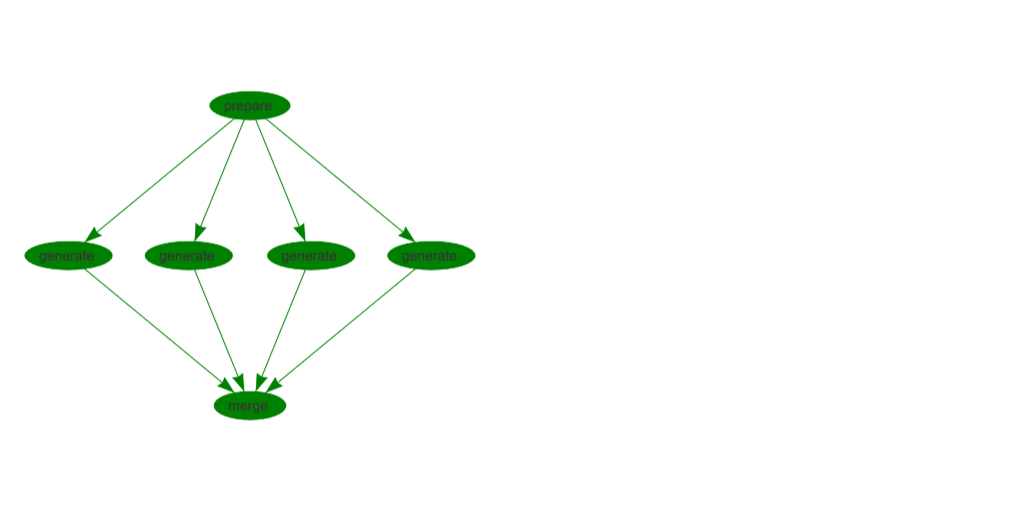

In [3]:
workdir = 'workdir'
workflow = setup_workflow(workdir = workdir, nevents = 40000, beamenergy = 40.0)
ui = yadage_widget.WorkflowWidget(workflow)
ui

In [4]:
backend = adage.backends.MultiProcBackend(psutil.cpu_count())
adage.rundag(workflow,
             update_interval = 3,
             default_trackers = False,
             additional_trackers=[ui.adagetracker],
             backend = backend)

In [5]:
%pylab
%matplotlib inline
import jsonlines

/home/main/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib


In [6]:
inputfile = '{}/merged.jsonl'.format(workdir)
costhetas = []
for i,e in enumerate(jsonlines.Reader(open(inputfile))):
    els = [p for p in e['particles'] if p['id'] == 11]
    mus = [p for p in e['particles'] if p['id'] == 13]
    assert len(mus) == 1
    assert len(els) == 1
    mu = mus[0]
    el = els[0]
    el_px, el_py, el_pz = [el[x] for x in ['px','py','pz']]
    mu_px, mu_py, mu_pz = [mu[x] for x in ['px','py','pz']]
    costheta = mu_pz/el_pz
    costhetas.append(costheta)

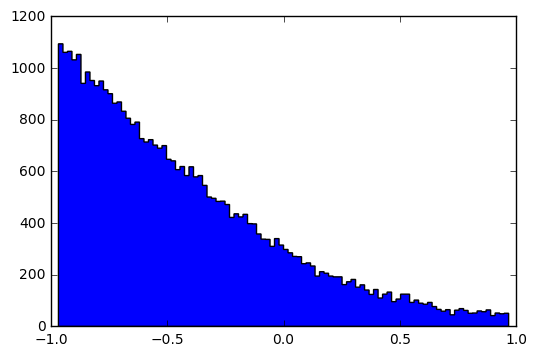

In [7]:
_,_,_ = plt.hist(costhetas, bins = 100, histtype='stepfilled')